### Quantitative Comparison:

##### Necessary Imports

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import urllib.request

import gc
import numpy as np
import torch.nn as nn


from sklearn import preprocessing
from sklearn.kernel_approximation import RBFSampler

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

##### Target Image

In [2]:
file_path = 'dog.jpg'
if os.path.exists(file_path):
    print('dog.jpg exists')
else:
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    urllib.request.urlretrieve(url, file_path)

dog.jpg exists


In [3]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


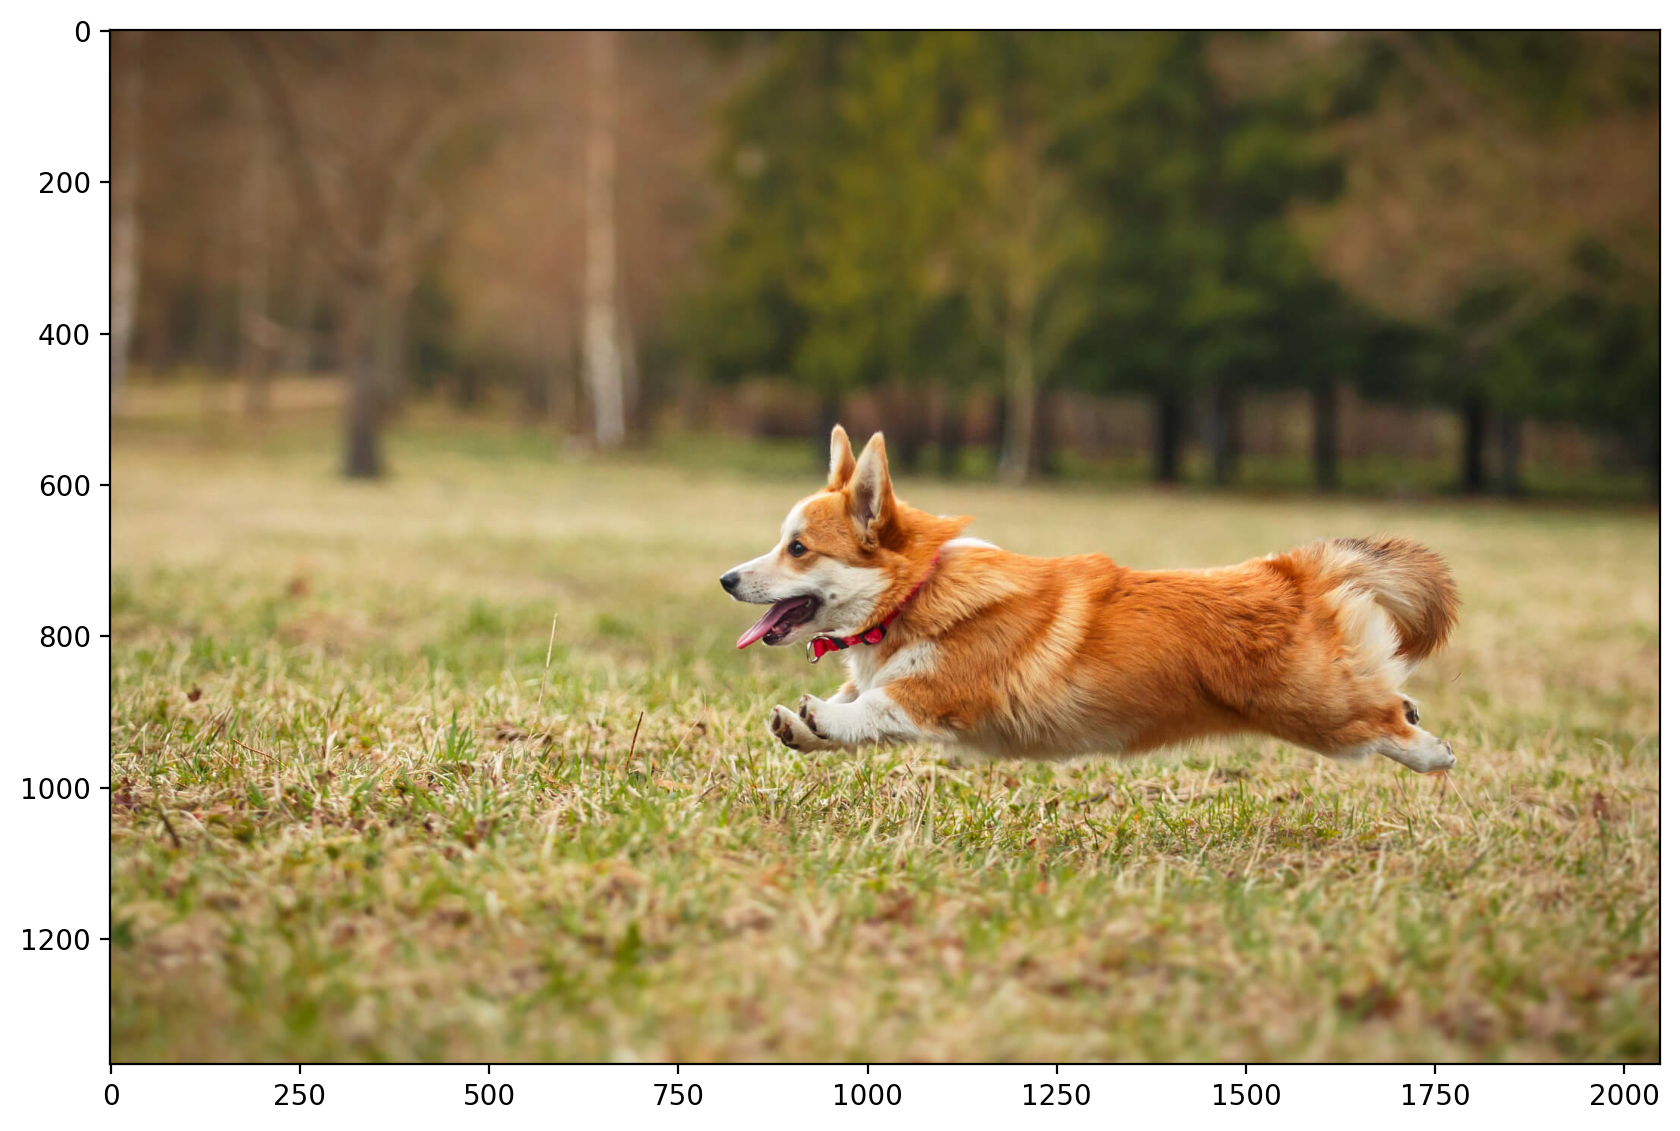

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

##### Scaling the Image RGB Values from $0$ to $1$ using the Min-Max Scaler

In [5]:
scaler = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler

MinMaxScaler()

In [6]:
scaled_img = scaler.transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img).float().to(device)
print(scaled_img.shape)
print(scaled_img)

torch.Size([3, 1365, 2048])
tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.14

##### Let's first take the Original Image (400 x 400)

In [7]:
OriginalImg = torchvision.transforms.functional.crop(scaled_img.cpu(), 550, 800, 400, 400)
print(OriginalImg.shape)

torch.Size([3, 400, 400])


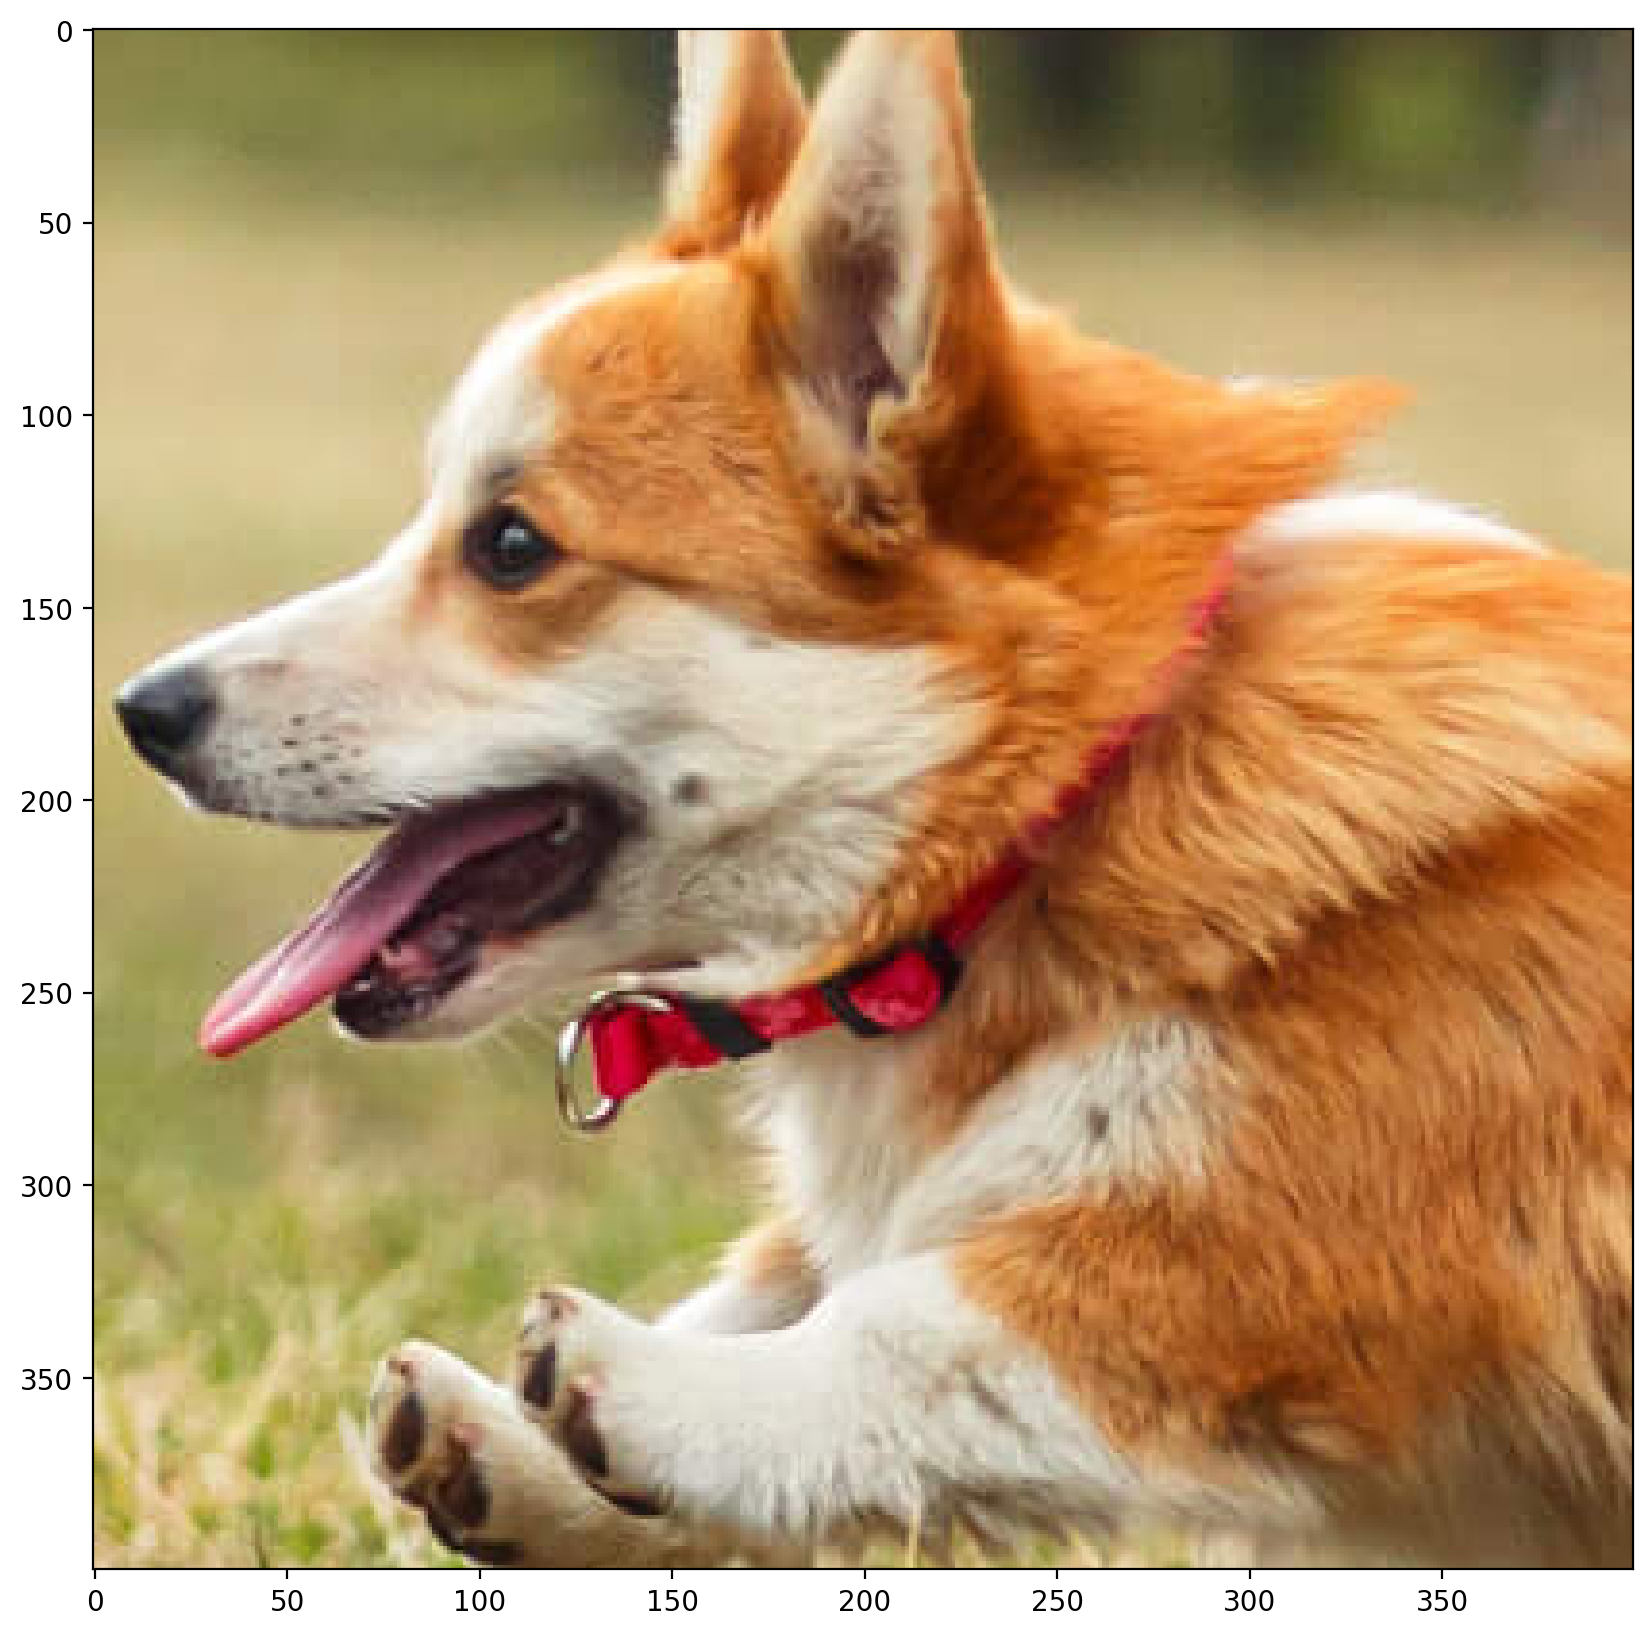

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

##### Function for Creating the Coordinate Map for a given Image and Scale

In [9]:
def create_coordinate_map(img, scale = 1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    height *= scale
    width *= scale

    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).float().to(device)

    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

##### Converting the Original Image into Low Resolution Image (200 x 200) Using 2D Convolution

In [10]:
scale = 2
num_channels, height, width = OriginalImg.shape
height //= scale
width //= scale
low_res_img = torch.zeros((num_channels,height,width)).to(device)
for i in range(height):
  for j in range(width):
    low_res_img[:, i, j] = torch.mean(OriginalImg[:, 2*i:2*i+2, 2*j:2*j+2], dim=(1, 2))
print(low_res_img.shape)

torch.Size([3, 200, 200])


In [11]:
import gc

gc.collect()

6

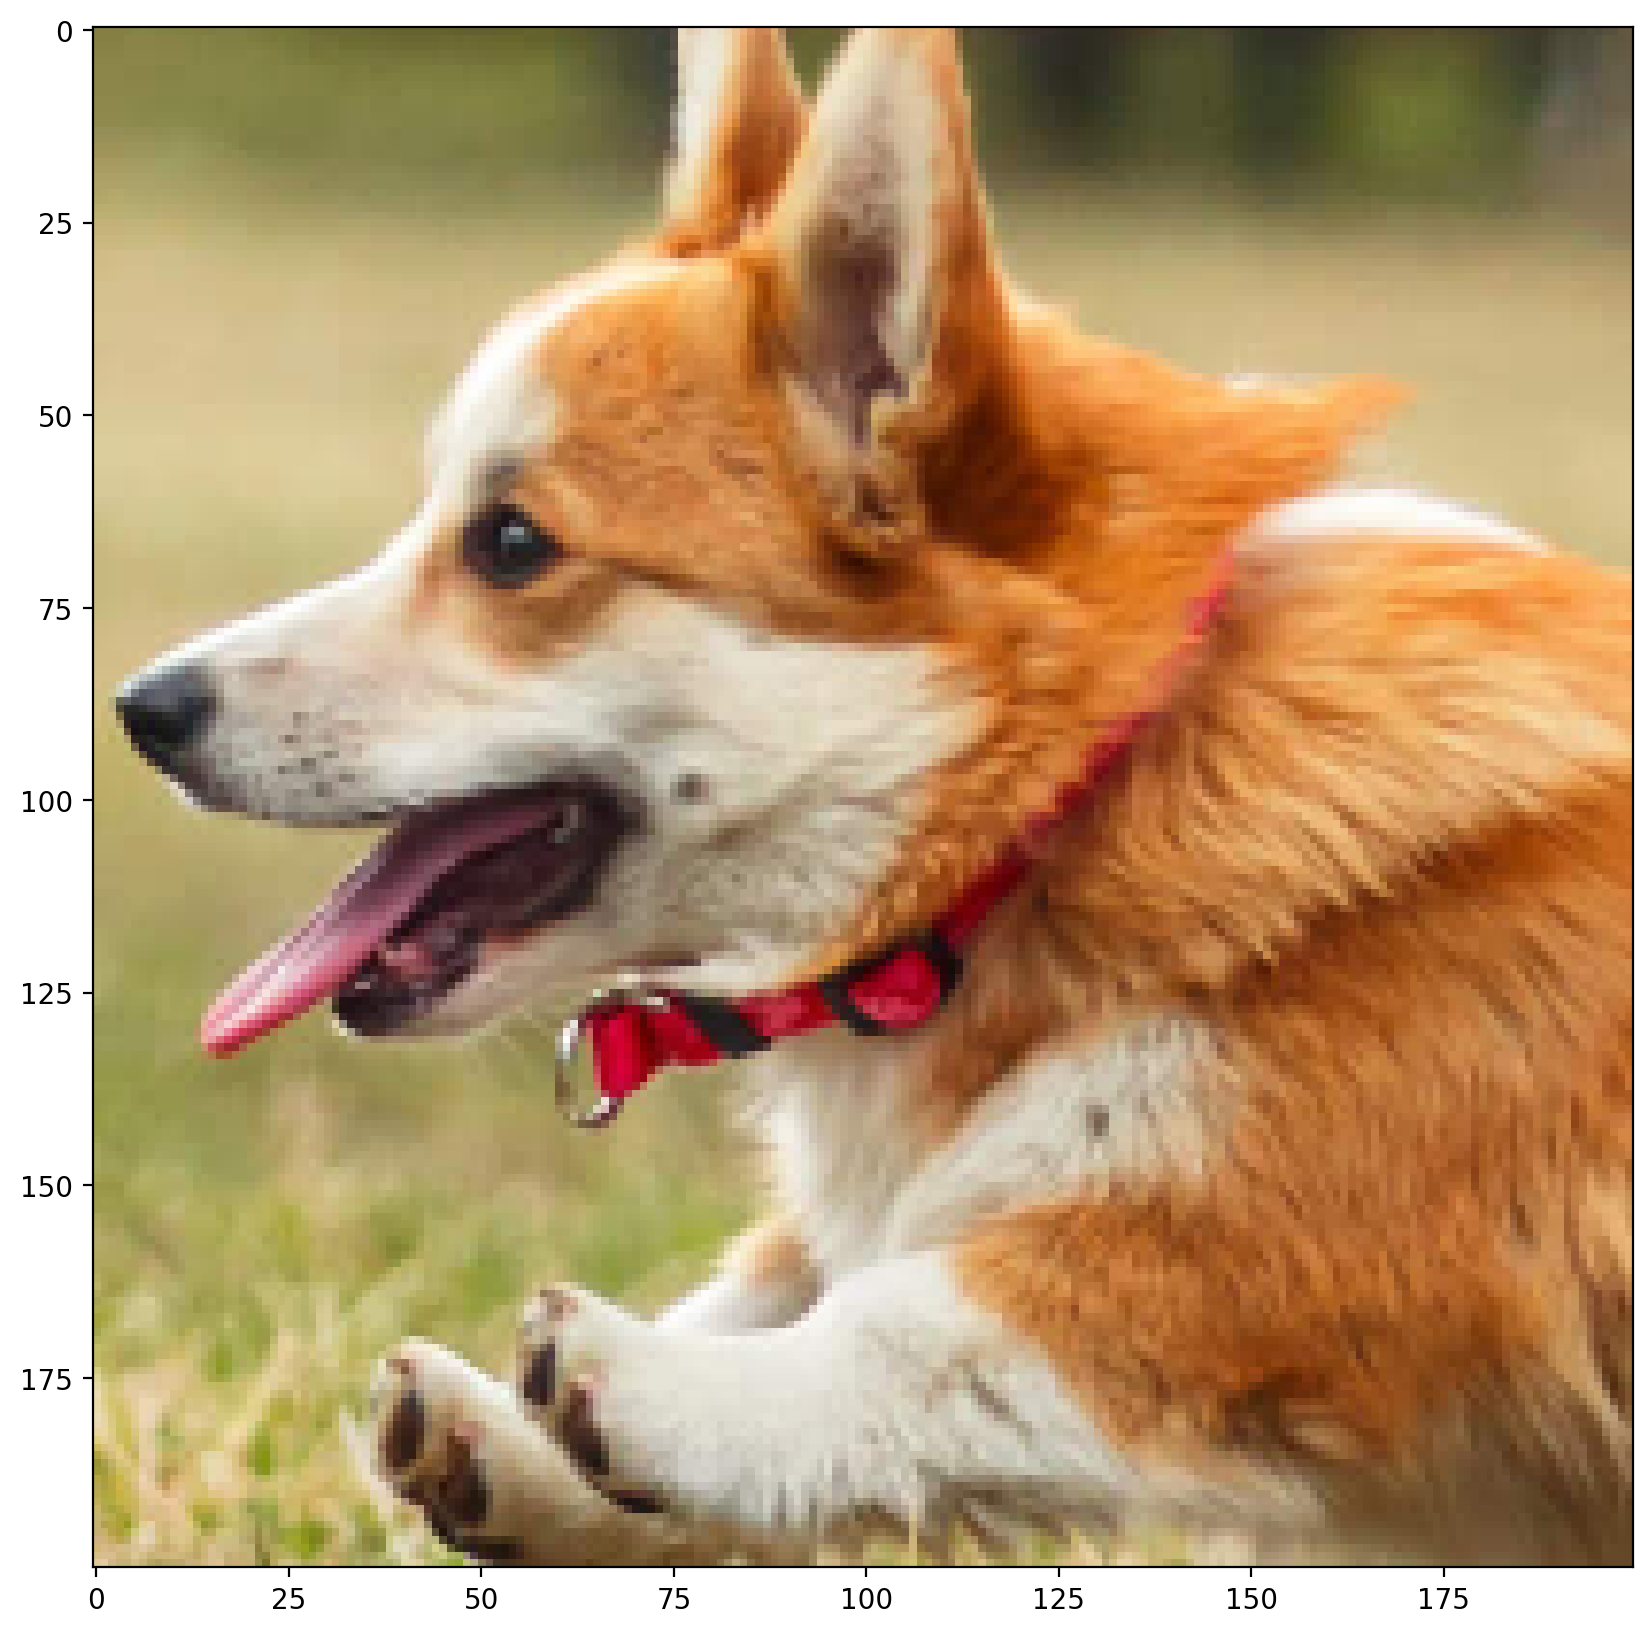

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(rearrange(low_res_img, 'c h w -> h w c').cpu().numpy())

In [13]:
X, Y = create_coordinate_map(low_res_img)
print("Shape of X = ",X.shape,"\nShape of Y = ", Y.shape)
print("X:\n",X,"\nY:\n", Y)

Shape of X =  torch.Size([40000, 2]) 
Shape of Y =  torch.Size([40000, 3])
X:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [199., 197.],
        [199., 198.],
        [199., 199.]]) 
Y:
 tensor([[0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        ...,
        [0.3961, 0.2824, 0.1569],
        [0.3971, 0.2833, 0.1578],
        [0.3990, 0.2853, 0.1598]])


##### Scaling using the Min-Max Scaler

In [14]:
scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X.cpu())
scaled_X = torch.tensor(scaler.transform(X.cpu())).float().to(device)
print(scaled_X.shape)
print(scaled_X)

torch.Size([40000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9899],
        [-1.0000, -0.9799],
        ...,
        [ 1.0000,  0.9799],
        [ 1.0000,  0.9899],
        [ 1.0000,  1.0000]])


##### Generating the Random Fourier Features for the Scaled_X

In [15]:
num_features = 10000
sigma = 0.03

In [16]:
rff = RBFSampler(n_components=num_features, gamma=1/(2*sigma**2), random_state=42)
X_rff = torch.tensor(rff.fit_transform(scaled_X.cpu().numpy())).float().to(device)
print(X_rff.shape)

torch.Size([40000, 10000])


In [17]:
print(X_rff)

tensor([[ 1.4030e-02, -7.5783e-03, -1.3837e-02,  ..., -1.3946e-02,
          1.1493e-02, -1.3086e-02],
        [ 1.4070e-02, -6.3188e-03, -1.4142e-02,  ..., -1.4131e-02,
          1.4126e-02, -1.3975e-02],
        [ 1.3385e-02, -4.9931e-03, -1.3882e-02,  ..., -1.4089e-02,
          1.2231e-02, -1.0848e-02],
        ...,
        [ 7.3025e-03, -7.2673e-03,  9.6413e-03,  ...,  1.3780e-02,
          7.6068e-03, -1.0545e-02],
        [ 9.8438e-03, -8.4687e-03,  1.1506e-02,  ...,  1.4072e-02,
         -8.6598e-05, -4.1631e-03],
        [ 1.1879e-02, -9.5816e-03,  1.2911e-02,  ...,  1.4137e-02,
         -7.7522e-03,  3.4149e-03]])


##### Function for Training the Linear Model on the Random Fourier Features

In [18]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [19]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    print(f"Epoch {epochs} loss: {loss.item():.6f}")
    return loss.item()

##### Training the Linear Model on the Random Fourier Features

In [20]:
in_features = X_rff.shape[1]
out_features = 3
net = LinearModel(in_features,out_features).to(device)
net

LinearModel(
  (linear): Linear(in_features=10000, out_features=3, bias=True)
)

In [21]:
Y = Y.to(device)
train(net, 0.01, X_rff, Y, 100)

Epoch 0 loss: 0.336285
Epoch 100 loss: 0.001899


0.0018985079368576407

In [22]:
import gc
del X_rff, X, Y, scaled_X
gc.collect()

20

##### Creating the Coordinate Map for the Enhanced Image (2x Scaled: 400 x 400)

In [23]:
X_, Y_ = create_coordinate_map(low_res_img, scale = 2)
print("Shape of X_ = ",X_.shape,"\nShape of Y_ = ", Y_.shape)
print("X_:\n",X_,"\nY_:\n", Y_)

Shape of X_ =  torch.Size([160000, 2]) 
Shape of Y_ =  torch.Size([40000, 3])
X_:
 tensor([[  0.,   0.],
        [  0.,   1.],
        [  0.,   2.],
        ...,
        [399., 397.],
        [399., 398.],
        [399., 399.]]) 
Y_:
 tensor([[0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        [0.5235, 0.5000, 0.2725],
        ...,
        [0.3961, 0.2824, 0.1569],
        [0.3971, 0.2833, 0.1578],
        [0.3990, 0.2853, 0.1598]])


##### Scaling X using Min-Max Scaler

In [24]:
scaler = preprocessing.MinMaxScaler(feature_range= (-1,1)).fit(X_.cpu())
scaled_X_ = torch.tensor(scaler.transform(X_.cpu())).float().to(device)
print(scaled_X_.shape)
print(scaled_X_)

torch.Size([160000, 2])
tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9950],
        [-1.0000, -0.9900],
        ...,
        [ 1.0000,  0.9900],
        [ 1.0000,  0.9950],
        [ 1.0000,  1.0000]])


##### Transforming the scaled_X to the Random Fourier Features

In [25]:
X_rff = rff.transform(scaled_X_.cpu().numpy())
X_rff = torch.tensor(X_rff).float().to(device)

In [26]:
print(X_rff.shape)
print(X_rff)

torch.Size([160000, 10000])
tensor([[ 0.0140, -0.0076, -0.0138,  ..., -0.0139,  0.0115, -0.0131],
        [ 0.0141, -0.0070, -0.0141,  ..., -0.0141,  0.0134, -0.0140],
        [ 0.0141, -0.0063, -0.0141,  ..., -0.0141,  0.0141, -0.0140],
        ...,
        [ 0.0098, -0.0085,  0.0115,  ...,  0.0141, -0.0001, -0.0041],
        [ 0.0109, -0.0090,  0.0123,  ...,  0.0141, -0.0041, -0.0004],
        [ 0.0119, -0.0096,  0.0129,  ...,  0.0141, -0.0078,  0.0034]])


##### Plotting the Original Image (400 x 400) & Predicted Enhanced Image (400 x 400)

In [27]:
def plot_Original_vs_Predicted_Img(OriginalImg, X_rff_pred, net, return_Output = 0):
    """
    OriginalImg: torch.Tensor of shape (num_channels, height, width)
    X_rff_pred: torch.Tensor of shape (num_samples, num_features)
    net: torch.nn.Module
    return_Output: int
    return: torch.Tensor of shape (num_channels, scale*height, scale*width)

    """
    num_channels, height, width = OriginalImg.shape

    with torch.no_grad():
        outputs = net(X_rff_pred)
        pred_img = outputs.to(device)
        print(pred_img.shape)
        pred_img = rearrange(pred_img, '(h w) c -> c h w', h=height, w=width)
    fig = plt.figure(figsize=(12,8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.set_title(f'Original Image ({height}x{width})')
    ax0.imshow(rearrange(OriginalImg, 'c h w -> h w c').cpu().numpy())

    ax1 = plt.subplot(gs[1])
    ax1.set_title(f'Predicted Image ({height}x{width})')
    ax1.imshow(rearrange(pred_img,'c h w -> h w c').cpu().detach().numpy())

    fig.suptitle('Original vs Predicted Image',fontsize=16, y=0.95)
    plt.tight_layout()
    if(return_Output == 1):
        return pred_img


torch.Size([160000, 3])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


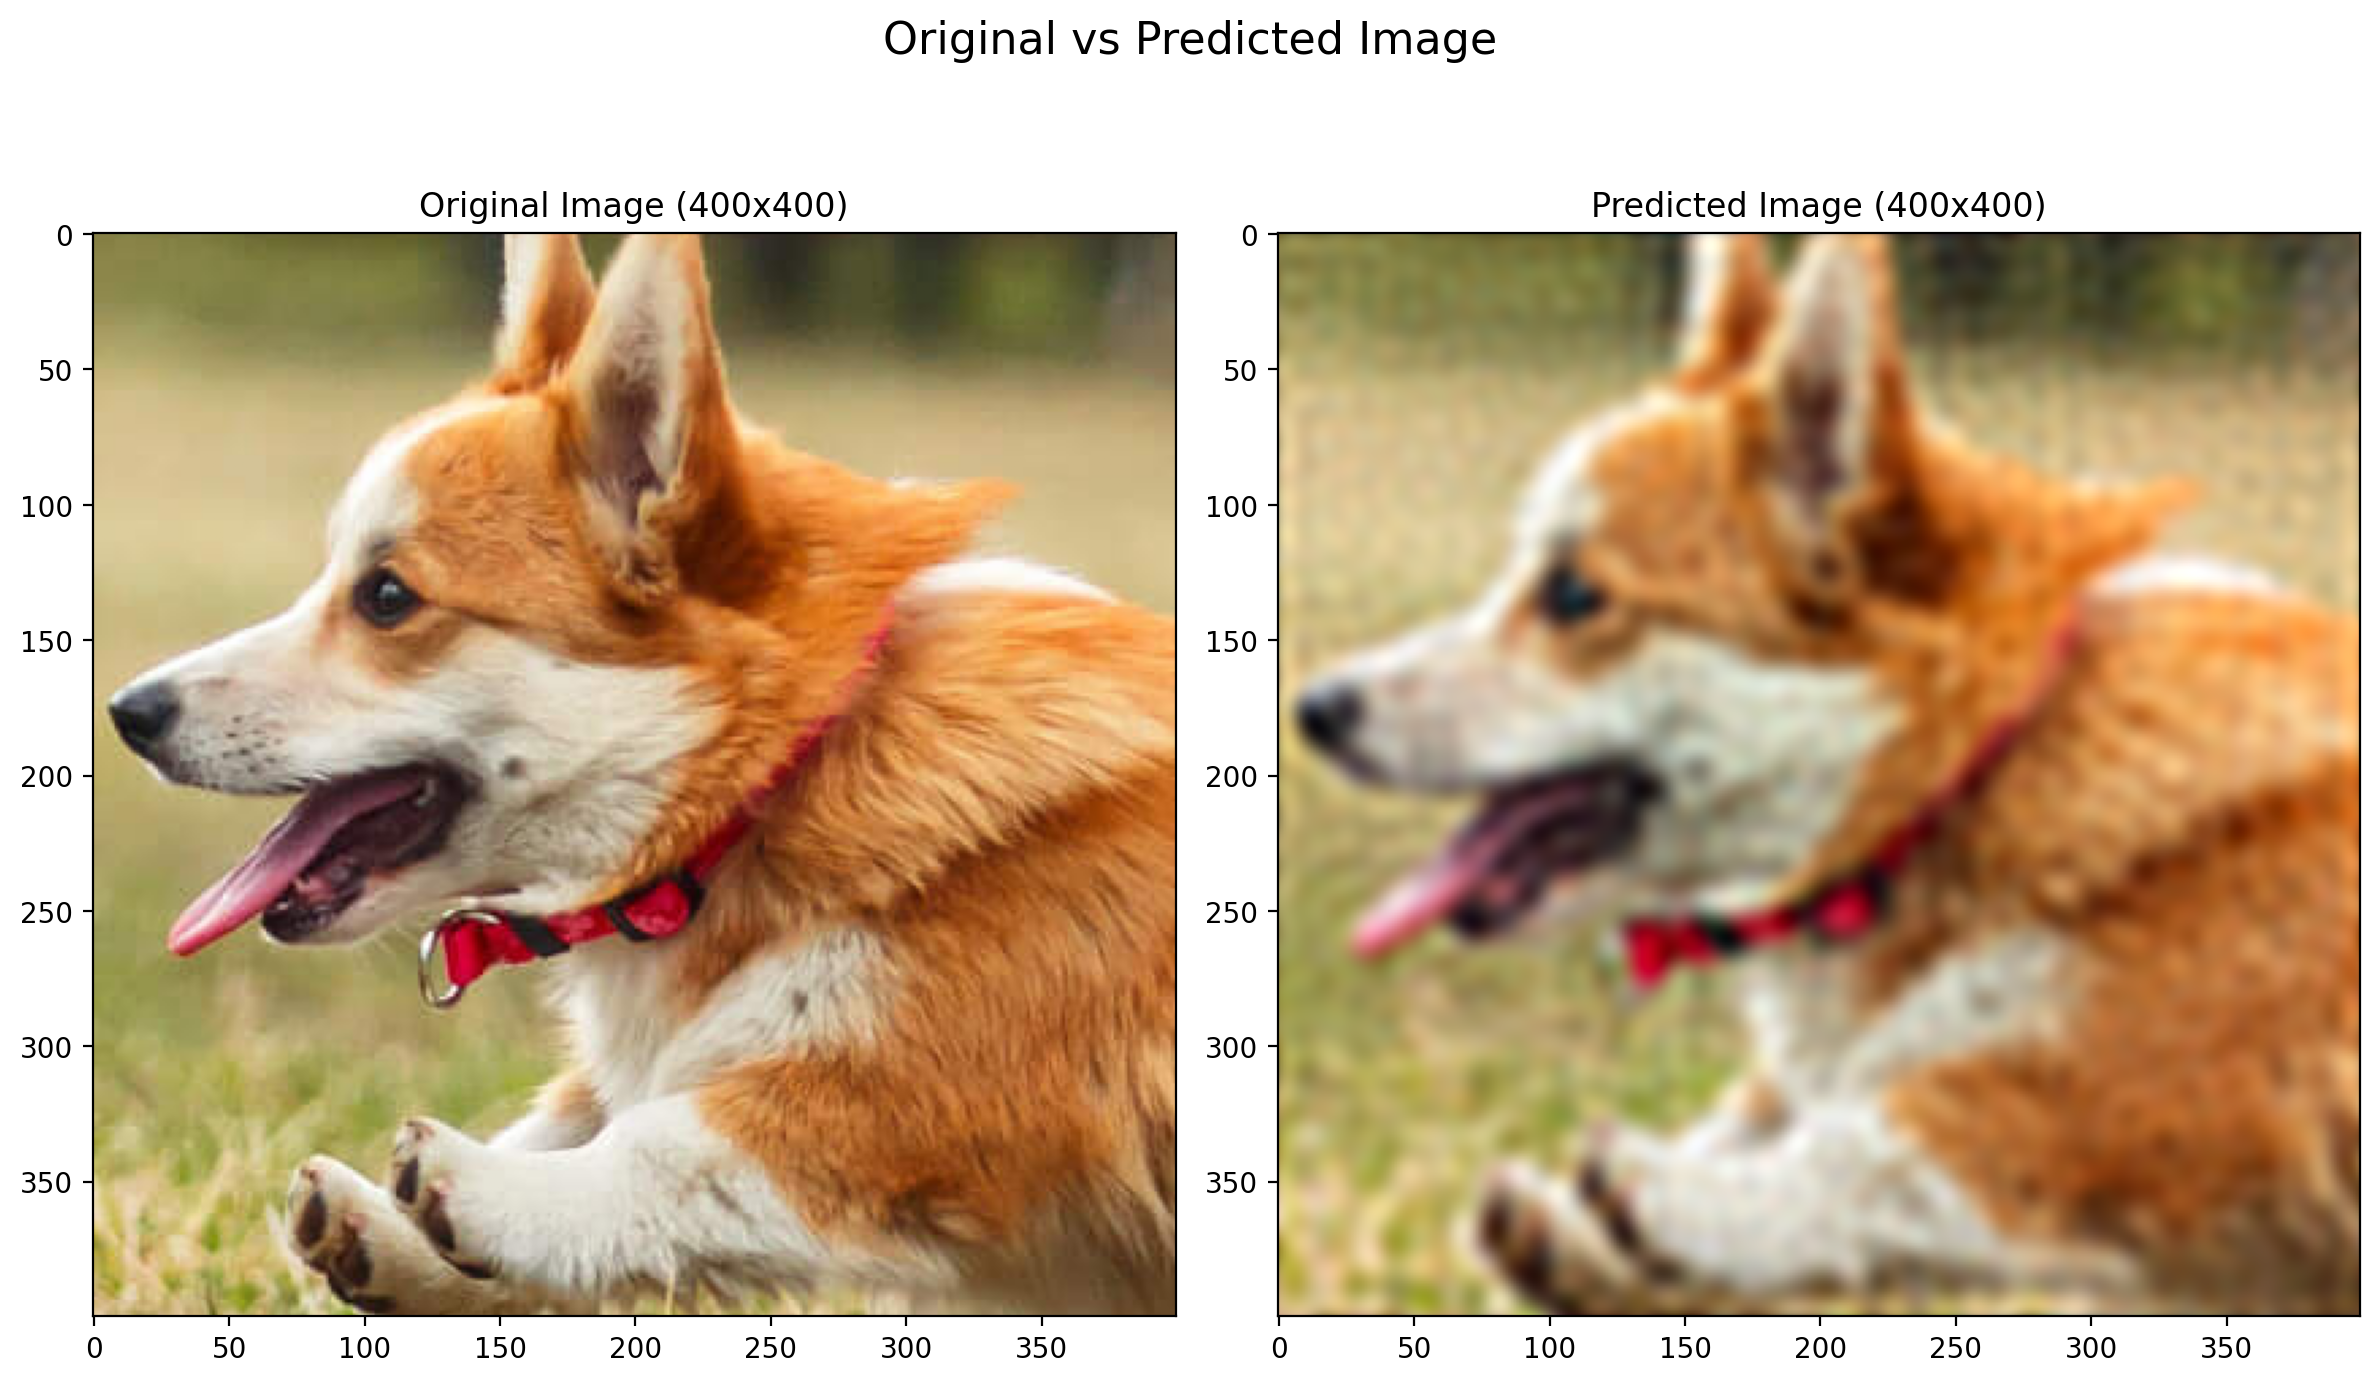

In [28]:
Y = plot_Original_vs_Predicted_Img(OriginalImg, X_rff, net, return_Output = 1)

##### Calculating Mean Squared Error and Peak Signal to Noise Ratio

In [34]:
def calRMSE_and_PSNR(img1,img2):
    """
    img1: torch.Tensor of shape (num_channels, height, width)
    img2: torch.Tensor of shape (num_channels, height, width)

    return: tuple of float and float
    """
    rmse = torch.sqrt(torch.mean((img1 - img2) ** 2))
    psnr = 20 * torch.log10(1.0 / rmse)
    return rmse.item(), psnr.item()


In [35]:
Y = Y.to(device)
rmse, psnr = calRMSE_and_PSNR(OriginalImg, Y)
print("RMSE: ", rmse, "\nPSNR: ", psnr)

RMSE:  0.08271342515945435 
PSNR:  21.648481369018555


In [36]:
gc.collect()

786